In [1]:
import os; os.chdir('../')
from tqdm import tqdm

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
%matplotlib inline

In [133]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import MNLDiscreteChoiceStep
from urbansim.utils import misc
from scripts import datasources, models
import orca

### Load data

In [57]:
chts_persons = pd.read_csv('/home/mgardner/data/chts-orig/data/Deliv_PER.csv', low_memory=False)

In [58]:
chts_persons_lookup = pd.read_csv('/home/mgardner/data/chts-orig/data/LookUp_PER.csv')

In [59]:
chts_persons = pd.merge(
    chts_persons.set_index(['SAMPN','PERNO']),
    chts_persons_lookup.set_index(['SAMPN','PERNO']),
    left_index=True, right_index=True,
    suffixes=('_persons', '_lookup')).reset_index()

In [60]:
chts_homes = pd.read_csv('/home/mgardner/data/chts-orig/data/LookUp_Home.csv')

In [61]:
chts_persons = pd.merge(chts_persons, chts_homes, on='SAMPN')

In [62]:
# SF Bay Area only!
chts_persons = chts_persons[chts_persons['HCTFIP'].isin([1, 13, 41, 55, 75, 81, 85, 95, 97])].reset_index()

In [10]:
jobs = pd.read_csv('/home/mgardner/data/jobs_w_occup.csv')

In [121]:
buildings = pd.read_hdf('./data/bayarea_ual.h5', 'buildings')

In [12]:
parcels = pd.read_hdf('./data/bayarea_ual.h5', 'parcels')

### Get job coords

In [122]:
buildings = pd.merge(buildings, parcels[['x', 'y']], left_on='parcel_id', right_index=True)

jobs = pd.merge(jobs, buildings[['x', 'y']], left_on='building_id', right_index=True)
jobs.rename(columns={'x': 'lng', 'y': 'lat'}, inplace=True)

### Assign jobs a node ID

In [17]:
# load the network nodes
nodes = pd.read_csv('~/data/bay_area_full_strongly_nodes.csv')
nodes = nodes.set_index('osmid')
assert nodes.index.is_unique

In [63]:
# haversine requires data in form of [lat, lng] and inputs/outputs in units of radians
nodes_rad = np.deg2rad(nodes[['y', 'x']])
persons_rad = np.deg2rad(chts_persons[['WYCORD_lookup', 'WXCORD_lookup']])
jobs_rad = np.deg2rad(jobs[['lng', 'lat']])

In [19]:
# build the tree for fast nearest-neighbor search
tree = BallTree(nodes_rad, metric='haversine')

In [20]:
# query the tree for nearest node to each home
idx = tree.query(jobs_rad, return_distance=False)
jobs['node_id'] = nodes.iloc[idx[:,0]].index

In [22]:
jobs.to_csv('/home/mgardner/data/jobs_w_occup_and_node.csv', index=False)

### Assign CHTS persons a job ID

In [64]:
dists = []
no_job_info = []
no_work_coords = []

# new columnd in CHTS persons to store job_id
chts_persons.loc[:, 'job_id'] = None

# prepare jobs table
jobs.loc[:, 'taken'] = False
jobs.loc[:, 'x'] = jobs_rad['lng']
jobs.loc[:, 'y'] = jobs_rad['lat']

for i, person in tqdm(chts_persons.iterrows(), total=len(chts_persons)):
    
    # only assign a job ID for employed persons with a fixed work location
    if (person['EMPLY'] == 1) & (person['WLOC'] == 1):
        
        # skip person if no CHTS industry or occupation
        if (person['INDUS'] > 96) & (person['OCCUP'] > 96):
            no_job_info.append(i)
            continue
        
        # skip person if no work location
        elif pd.isnull(person[['WYCORD_lookup', 'WXCORD_lookup']]).any():
            no_work_coords.append(i)
            continue
        
        # if CHTS industry is unknown, match jobs based on occupation only
        elif person['INDUS'] > 96:
            potential_jobs = jobs[
                (jobs['occupation_id'] == person['OCCUP']) &
                (jobs['taken'] == False)]
        
        # if occupation is unknown, match jobs based on industry only
        elif person['OCCUP'] > 96:
            potential_jobs = jobs[
                (jobs['naics'] == person['INDUS']) &
                (jobs['taken'] == False)]
        
        elif (person['INDUS'] < 97) & (person['OCCUP'] < 97):
            
            # define potential jobs based on industry and occupation
            potential_jobs = jobs[
                (jobs['naics'] == person['INDUS']) &
                (jobs['occupation_id'] == person['OCCUP']) &
                (jobs['taken'] == False)]
            
            # if no such jobs exist, define jobs by industry
            if len(potential_jobs) == 0:
                potential_jobs = jobs[
                    (jobs['naics'] == person['INDUS']) &
                    (jobs['taken'] == False)]
                
            # if no such jobs exist, define jobs by occupation
            if len(potential_jobs) == 0:
                potential_jobs = jobs[
                    (jobs['occupation_id'] == person['OCCUP']) &
                    (jobs['taken'] == False)]
            
            # otherwise, continue
            if len(potential_jobs) == 0:
                continue
        
        # build the tree of potential jobs for fast nearest-neighbor search
        tree = BallTree(potential_jobs[['y','x']], metric='haversine')
        
        # query the tree for nearest job to each workplace
        dist, idx = tree.query(persons_rad.iloc[i].values.reshape(1,-1), return_distance=True)
        
        # save results
        job = potential_jobs.iloc[idx[0][0]]
        dists.append(dist[0][0])
        chts_persons.loc[i, 'job_id'] = job['job_id']
        jobs.loc[jobs['job_id'] == job['job_id'], 'taken'] = True 


100%|██████████| 24030/24030 [24:09<00:00, 16.57it/s]


In [65]:
chts_persons.to_csv('./data/chts_persons_with_job_id.csv', index=False)

In [103]:
# convert dists from radians to kilometers
dists = [dist * 6371 for dist in dists]

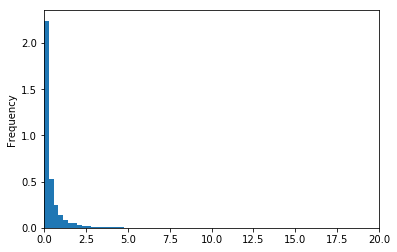

In [113]:
pd.Series(dists).plot(kind='hist', bins=20000, xlim=(0, 20), normed=True)

In [114]:
print('Assigned job IDs to {0}% of workers with a fixed work location.'.format(
    np.round(chts_persons.job_id.count() / len(
        chts_persons[(chts_persons['EMPLY'] == 1)  & (chts_persons['WLOC'] == 1)]) * 100, 1)))
print('{0}% had no industry/occupation info.'.format(
    np.round(len(no_job_info) / len(
        chts_persons[(chts_persons['EMPLY'] == 1)  & (chts_persons['WLOC'] == 1)]) * 100, 1)))
print('{0}% had no work coordinates.'.format(
    np.round(len(no_work_coords) / len(
        chts_persons[(chts_persons['EMPLY'] == 1)  & (chts_persons['WLOC'] == 1)]) * 100, 1)))

Assigned job IDs to 98.1% of workers with a fixed work location.
1.8% had no industry/occupation info.
0.0% had no work coordinates.
